# Road to a Five-star Restaurant

*** A guide to restaurants owners in Arizona ***

### Part 1 Where are yelp restaurants in North Amarica and Arizona?

In [1]:
import pymysql
import pandas as pd
import numpy as np

In [2]:
conn = pymysql.connect('yelptest.cvoledglu2l2.us-east-1.rds.amazonaws.com', 'admin', 'adminadmin', 'yelp_db') 

#### Count restaurants by state and make a map

In [67]:
sql = '''
      select a.state, avg(a.latitude) as lat, avg(a.longitude) as lon, count(*) as count
      from business a
      join category b
      on a.id = b.business_id
      where state not in ('BW', 'EDH')
      and category = 'Restaurants'
      group by a.state
      order by count desc
      limit 10;
      '''

state_count = pd.io.sql.read_sql(sql, conn)
print(state_count)

  state        lat         lon  count
0    ON  43.713400  -79.431042  12634
1    AZ  33.488988 -111.998580  10219
2    NV  36.123016 -115.138704   6883
3    QC  45.516902  -73.614115   4567
4    OH  41.422488  -81.650667   4513
5    NC  35.232322  -80.829244   3625
6    PA  40.436904  -79.954072   3435
7    WI  43.075025  -89.404662   1486
8    IL  40.114217  -88.247607    598
9    SC  35.036487  -80.944030    201


In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import cm

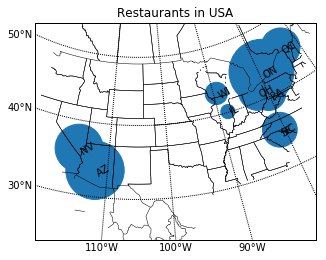

In [69]:
# Make bubble plot map
map = Basemap(projection='stere',lat_0=90,lon_0=-105,\
            llcrnrlat=23.41 ,urcrnrlat=45.44,\
            llcrnrlon=-118.67,urcrnrlon=-64.52,\
            rsphere=6371200.,resolution='l',area_thresh=10000)
map.drawmapboundary()
#map.fillcontinents()
map.drawstates()
#map.drawcoastlines()
map.drawcountries()
#map.drawcounties()
parallels = np.arange(0.,90,10.) 
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
meridians = np.arange(-110.,-60.,10.)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
lat = np.array(state_count["lat"])
lon = np.array(state_count["lon"])
count = np.array(state_count["count"],dtype=float)
size = count/3
x,y = map(lon,lat)
map.scatter(x, y, s=size)
for x, y, each in zip(x, y, state_count["state"]):
    plt.text(x-5, y, each,rotation=30,fontsize=10)
plt.title('Restaurants in USA')
plt.show()

* From the map, We can see that in the dataset, Arizona owns the most of restaurants in the United States. Therefore, we chose State of Arizona as our research target.

#### Count restaurants by city in Arizona and make a map

In [70]:
sql = '''
      select a.city, avg(a.latitude) as lat, avg(a.longitude) as lon, count(*) as count
      from business a
      join category b
      on a.id = b.business_id
      where state = 'AZ'
      and category = 'Restaurants'
      group by a.city
      order by count desc
      limit 10;
      '''

city_count = pd.io.sql.read_sql(sql, conn)
print(city_count)

         city        lat         lon  count
0     Phoenix  33.519408 -112.063738   3515
1  Scottsdale  33.569279 -111.911120   1414
2        Mesa  33.403175 -111.773505   1093
3       Tempe  33.399359 -111.934085    926
4    Chandler  33.300180 -111.874855    789
5    Glendale  33.597235 -112.196245    636
6     Gilbert  33.330481 -111.765502    496
7      Peoria  33.628562 -112.246681    329
8    Surprise  33.634299 -112.374431    202
9    Avondale  33.459615 -112.315677    164


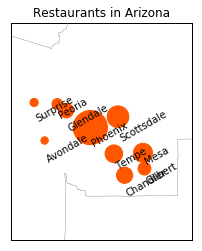

In [71]:
map = Basemap(projection='stere',lat_0=33.5,lon_0=-112,\
            llcrnrlat=33 ,urcrnrlat=34,\
            llcrnrlon=-112.5,urcrnrlon=-111.5,\
            rsphere=6371200.,resolution='l',area_thresh=10000)
map.drawmapboundary()
#map.fillcontinents()
map.drawstates()
#map.drawcoastlines()
map.drawcountries()
map.drawcounties()
parallels = np.arange(0.,90,10.) 
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
meridians = np.arange(-110.,-60.,10.)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
lat = np.array(city_count["lat"])
lon = np.array(city_count["lon"])
count = np.array(city_count["count"],dtype=float)
size = count/3
x,y = map(lon,lat)
map.scatter(x,y,s=size,color='#FF5600')
for x, y, each in zip(x, y, city_count["city"]):
    plt.text(x, y, each,rotation=30,fontsize=10)
plt.title('Restaurants in Arizona')
plt.show()

* We can see that in the dataset, most of restaurants in Arizona are around Phoenix.

### Part 2 What makes a 5-star restaurant in Arizona

*** In this part, we use descriptive analysis to probe the secret that what makes a 5 star restaurants ***

#### Count the number of restaurants by star rating

In [72]:
sql = '''
      SELECT stars, count(*) as numbers FROM business
      join category on category.business_id=business.id
      where business.state like "AZ"
      AND category.category="Restaurants"
      group by stars
      order by stars DESC;
      '''

business_star = pd.io.sql.read_sql(sql, conn)
print(business_star)

   stars  numbers
0    5.0      222
1    4.5     1093
2    4.0     2574
3    3.5     2440
4    3.0     1827
5    2.5     1139
6    2.0      618
7    1.5      234
8    1.0       72


Text(0,0.5,'numbers')

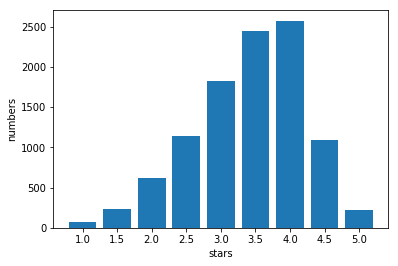

In [73]:
business_star['stars'] = business_star['stars'].astype('str')
plt.bar(business_star['stars'],business_star['numbers'])  
plt.xlabel('stars')  
plt.ylabel('numbers')  

* Large parts of restaurants are distributed around 3.5 stars or 4 stars, which is consistent with the fact that the average star rating is 3.7.

#### Count the number of restaurants by star rating (5 star VS. non 5 star)

In [8]:
# Review count by star class (non-Elite only)
sql = '''
    SELECT DISTINCT count(review.stars) as non_elite_reviews, category.category as category, business.stars as stars \
    FROM review, business, category, user
    LEFT JOIN elite_years
    ON user.id = elite_years.user_id
    WHERE elite_years.user_id IS NULL
    AND state Like "AZ"
    AND category Like "Restaurants"
    AND review.business_id = business.id
    AND category.business_id = business.id
    AND review.user_id = user.id
    AND elite_years.user_id IS NULL
    GROUP BY stars
    ORDER by stars DESC;
      '''

countbystar_non_elite = pd.io.sql.read_sql(sql, conn)
print(countbystar_non_elite)

   non_elite_reviews     category  stars
0               4700  Restaurants    5.0
1             114204  Restaurants    4.5
2             268960  Restaurants    4.0
3             169419  Restaurants    3.5
4              75607  Restaurants    3.0
5              31770  Restaurants    2.5
6               9338  Restaurants    2.0
7               3259  Restaurants    1.5
8                511  Restaurants    1.0


In [79]:
# Review count by star class (Elite only)
sql = '''
    SELECT count(review.stars) as elite_reviews, category.category as category, business.stars as stars 
    FROM review, business, category, elite_years, user 
    WHERE state Like "AZ" 
    AND category Like "Restaurants" 
    AND review.business_id = business.id 
    AND category.business_id = business.id 
    AND elite_years.user_id=user.id 
    AND review.user_id = user.id 
    GROUP BY category.category, business.stars
    ORDER by stars DESC;
      '''

countbystar_elite = pd.io.sql.read_sql(sql, conn)
print(countbystar_elite)

   elite_reviews     category  stars
0           2356  Restaurants    5.0
1          89852  Restaurants    4.5
2         270190  Restaurants    4.0
3         174040  Restaurants    3.5
4          74315  Restaurants    3.0
5          26988  Restaurants    2.5
6           6876  Restaurants    2.0
7           1718  Restaurants    1.5
8            185  Restaurants    1.0


Text(0,0.5,'non_elite_reviews')

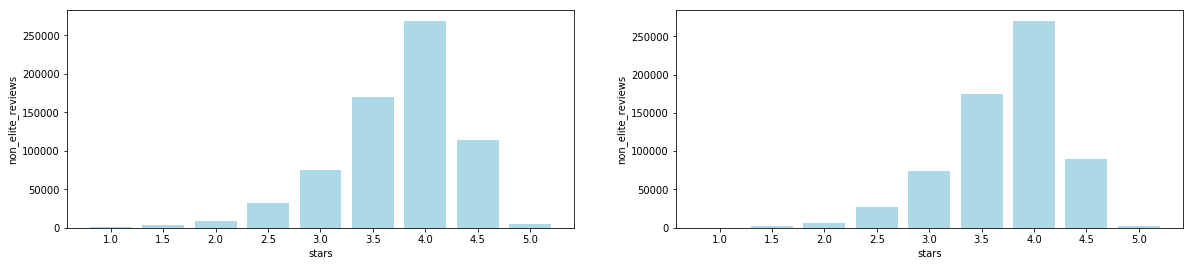

In [80]:
fig = plt.figure(figsize=[20,4])
fig.add_subplot(121)
countbystar_non_elite['stars'] = countbystar_non_elite['stars'].astype('str')
plt.bar(countbystar_non_elite['stars'],countbystar_non_elite['non_elite_reviews'], color = 'lightblue')  
plt.xlabel('stars')  
plt.ylabel('non_elite_reviews') 
fig.add_subplot(122)
countbystar_elite['stars'] = countbystar_elite['stars'].astype('str')
plt.bar(countbystar_elite['stars'],countbystar_elite['elite_reviews'], color = 'lightblue')  
plt.xlabel('stars')  
plt.ylabel('non_elite_reviews') 

* There are no significant difference on the distribution of restaurants by star rating

### Review score by star class (all)

In [81]:
sql = '''
    SELECT avg(review.stars) as avg_all_reviews, category.category as category, business.stars as stars
    FROM review, business, category
    WHERE state Like "AZ"
    AND category Like "Restaurants"
    AND review.business_id = business.id
    AND category.business_id = business.id
    GROUP BY category.category, business.stars
    ORDER by stars DESC;
      '''

scorebystar_all = pd.io.sql.read_sql(sql, conn)
print(scorebystar_all)

   avg_all_reviews     category  stars
0           4.8326  Restaurants    5.0
1           4.4171  Restaurants    4.5
2           3.9966  Restaurants    4.0
3           3.5262  Restaurants    3.5
4           3.0337  Restaurants    3.0
5           2.5477  Restaurants    2.5
6           2.0280  Restaurants    2.0
7           1.5539  Restaurants    1.5
8           1.1439  Restaurants    1.0


Text(0,0.5,'avg_all_reviews')

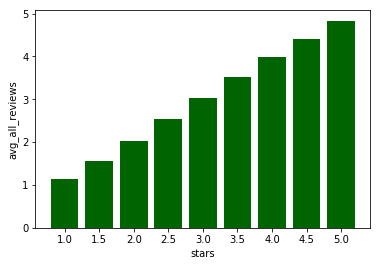

In [82]:
scorebystar_all['stars'] = scorebystar_all['stars'].astype('str')
plt.bar(scorebystar_all['stars'],scorebystar_all['avg_all_reviews'], color = 'darkgreen')  
plt.xlabel('stars')  
plt.ylabel('avg_all_reviews') 

* The reviews are positively correlated to the star rating.

### Review count by star class (non-Elite only)

In [83]:
sql = '''
    SELECT avg(review.stars) as non_Elite_reviews, category.category as category, business.stars as stars
    FROM review, business, category, user 
    LEFT JOIN elite_years 
    ON user.id = elite_years.user_id 
    WHERE elite_years.user_id IS NULL 
    AND state Like "AZ" 
    AND category Like "Restaurants" 
    AND review.business_id = business.id 
    AND category.business_id = business.id 
    AND review.user_id = user.id 
    AND elite_years.user_id IS NULL 
    GROUP BY category.category, business.stars
    ORDER by stars DESC;
      '''

scorebystar_non_elite = pd.io.sql.read_sql(sql, conn)
print(scorebystar_non_elite)

   non_Elite_reviews     category  stars
0             4.8453  Restaurants    5.0
1             4.4412  Restaurants    4.5
2             3.9979  Restaurants    4.0
3             3.5002  Restaurants    3.5
4             2.9731  Restaurants    3.0
5             2.4545  Restaurants    2.5
6             1.9256  Restaurants    2.0
7             1.4643  Restaurants    1.5
8             1.1174  Restaurants    1.0


### Review count by star class (Elite only)

In [13]:
sql = '''
    SELECT avg(review.stars) as avg_Elite_reviews, category.category as category, business.stars as stars 
    FROM review, business, category, elite_years, user 
    WHERE state Like "AZ" 
    AND category Like "Restaurants" 
    AND review.business_id = business.id 
    AND category.business_id = business.id 
    AND elite_years.user_id=user.id 
    AND review.user_id = user.id 
    GROUP BY category.category, business.stars
    ORDER by stars DESC;
      '''

scorebystar_elite = pd.io.sql.read_sql(sql, conn)
print(scorebystar_elite)

   avg_Elite_reviews     category  stars
0             4.7322  Restaurants    5.0
1             4.2604  Restaurants    4.5
2             3.9536  Restaurants    4.0
3             3.5927  Restaurants    3.5
4             3.2606  Restaurants    3.0
5             3.0002  Restaurants    2.5
6             2.5993  Restaurants    2.0
7             2.2660  Restaurants    1.5
8             1.4595  Restaurants    1.0


Text(0,0.5,'avg_Elite_reviews')

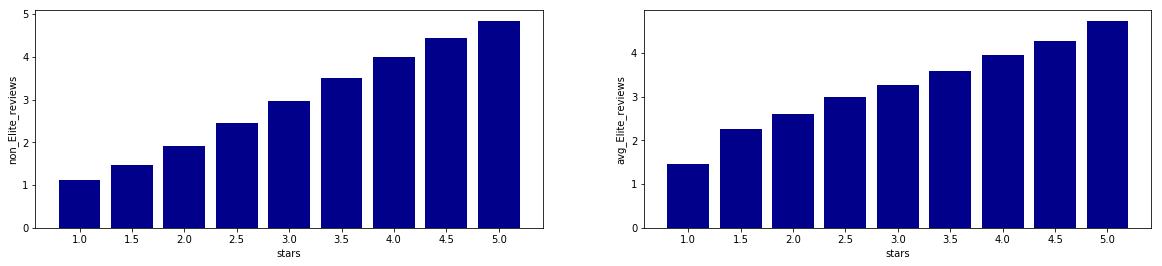

In [85]:
fig = plt.figure(figsize=[20,4])
fig.add_subplot(121)
scorebystar_non_elite['stars'] = scorebystar_non_elite['stars'].astype('str')
plt.bar(scorebystar_non_elite['stars'],scorebystar_non_elite['non_Elite_reviews'], color = 'darkblue')  
plt.xlabel('stars')  
plt.ylabel('non_Elite_reviews') 
fig.add_subplot(122)
scorebystar_elite['stars'] = scorebystar_elite['stars'].astype('str')
plt.bar(scorebystar_elite['stars'],scorebystar_elite['avg_Elite_reviews'], color = 'darkblue')  
plt.xlabel('stars')  
plt.ylabel('avg_Elite_reviews') 

* The reviews are positively correlated to the star rating, no matter from Elite Users or non Elite Users.

### Calculate checkins by star rating

In [103]:
sql = '''
      SELECT stars, count(checkin.count) as numbers FROM business 
      join category on category.business_id=business.id 
      join checkin on checkin.business_id=business.id
      where business.state like "AZ" 
      AND category.category="Restaurants"
      group by stars  
      order by stars DESC  
      limit 10;
      '''
business_3 = pd.io.sql.read_sql(sql, conn)

Text(0,0.5,'checkins')

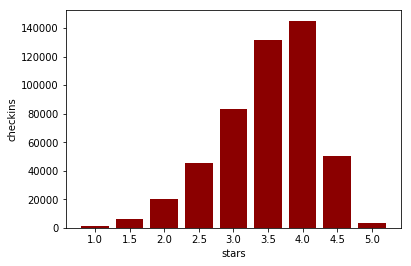

In [104]:
business_3['stars'] = business_3['stars'].astype('str')
plt.bar(business_3['stars'],business_3['numbers'], color = 'darkred')  
plt.xlabel('stars')  
plt.ylabel('checkins') 

* The distribution are similar to number of restaurants

### Count the checkins by day of week (5-star VS. non 5-star)

In [105]:
sql = '''
      SELECT a.day, sum(a.count) as checkin
      FROM
      (SELECT checkin.business_id, substr(date, 1, locate('-', date)-1) as day, count
      FROM checkin
      JOIN category on category.business_id=checkin.business_id
      JOIN business on business.id = checkin.business_id
      WHERE business.state like "AZ"
      AND category.category="Restaurants"
      AND business.stars = 5) a
      GROUP BY a.day;
      '''
business_4_1 = pd.io.sql.read_sql(sql, conn)

In [106]:
sql = '''
      SELECT a.day, sum(a.count) as checkin
      FROM
      (SELECT checkin.business_id, substr(date, 1, locate('-', date)-1) as day, count
      FROM checkin
      JOIN category on category.business_id=checkin.business_id
      JOIN business on business.id = checkin.business_id
      WHERE business.state like "AZ"
      AND category.category="Restaurants"
      AND business.stars < 5) a
      GROUP BY a.day;
      '''
business_4_2 = pd.io.sql.read_sql(sql, conn)

In [107]:
day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_num = ['1-Monday', '2-Tuesday', '3-Wednesday', '4-Thursday', '5-Friday', '6-Saturday', '7-Sunday']
weekday = pd.DataFrame(day,day_num)
weekday['index'] = weekday.index
weekday.columns = ['day','day_num']

In [108]:
business_4_1 = business_4_1.merge(weekday).sort_values(by = 'day_num',ascending = 1).reset_index().drop(['index','day'],axis = 1)
business_4_2 = business_4_2.merge(weekday).sort_values(by = 'day_num',ascending = 1).reset_index().drop(['index','day'],axis = 1)

Text(0,0.5,'non 5-star checkin')

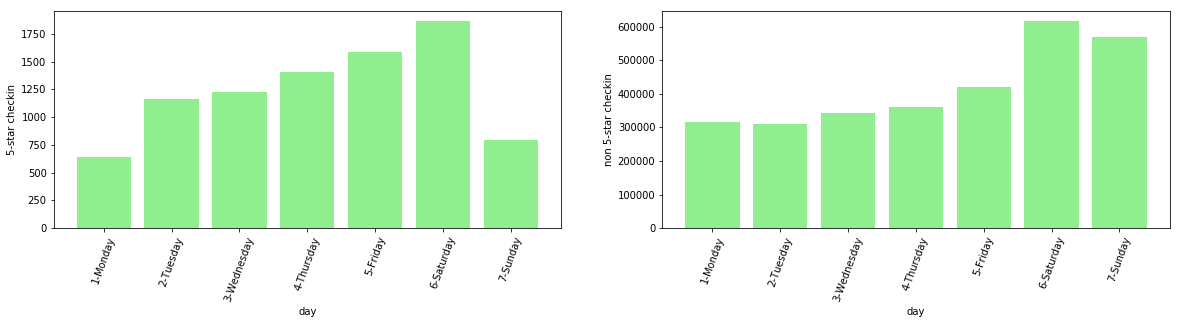

In [109]:
fig = plt.figure(figsize=[20,4])
fig.add_subplot(121)
plt.bar(business_4_1['day_num'], business_4_1['checkin'], color = 'lightgreen')  
plt.xticks(rotation = 70)
plt.xlabel('day')  
plt.ylabel('5-star checkin')
fig.add_subplot(122)
plt.bar(business_4_2['day_num'], business_4_2['checkin'], color = 'lightgreen')  
plt.xticks(rotation = 70)
plt.xlabel('day')  
plt.ylabel('non 5-star checkin')

* The checkin peak appears on Saturday for both 5-star or non 5-star restaurant but non 5-star restaurant have more checkins on weekends and 5-star restaurants have more checkins from Tuesdays to Fridays than Sunday.

### Calculate the average review score by calendar month

In [91]:
sql = '''
      select b.stars, month(a.date) as month, avg(a.stars) as scores
      from review a
      join business b
      on a.business_id = b.id
      join category c
      on b.id = c.business_id
      where c.category = 'Restaurants'
      and b.state = 'AZ'
      group by b.stars, month(a.date)
      ;
      '''

monthly_stars = pd.io.sql.read_sql(sql, conn)

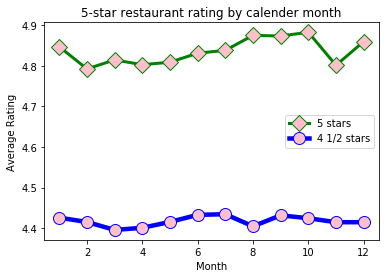

In [92]:
plt.plot(monthly_stars[monthly_stars['stars'] == 5]['month'], monthly_stars[monthly_stars['stars'] == 5]['scores'], label='5 stars',linewidth=3,color='g',marker='D', markerfacecolor='pink',markersize=12)
plt.plot(monthly_stars[monthly_stars['stars'] == 4.5]['month'], monthly_stars[monthly_stars['stars'] == 4.5]['scores'], label='4 1/2 stars',linewidth=4.5,color='b',marker='o', markerfacecolor='pink',markersize=12)
#plt.plot(monthly_stars[monthly_stars['stars'] == 4]['month'], monthly_stars[monthly_stars['stars'] == 4]['scores'], label='4 stars',linewidth=4.5,color='r',marker='o', markerfacecolor='pink',markersize=12)
plt.title('5-star restaurant rating by calendar month')
plt.xlabel('Month') 
plt.ylabel('Average Rating') 
plt.legend() 
plt.show()

* The highest scores from review by calendar month are in August, Sepetember and October; the lowest are in February and November

### Calculate the average review score by  months that restaurants have started business

In [93]:
sql = '''
      select b.id, b.stars, (100 * year(a.date) + month(a.date)) as yearmonth, avg(a.stars) as scores
      from review a
      join business b
      on a.business_id = b.id
      join category c
      on b.id = c.business_id
      where c.category = 'Restaurants'
      and b.state = 'AZ'
      group by b.id, b.stars, yearmonth
      order by id, yearmonth
      ;
      '''

month_stars = pd.io.sql.read_sql(sql, conn)

In [94]:
month_stars['month'] = month_stars.groupby(['id', 'stars']).rank()['yearmonth']
month_stars = month_stars.groupby(['stars', 'month']).mean()['scores'].reset_index()

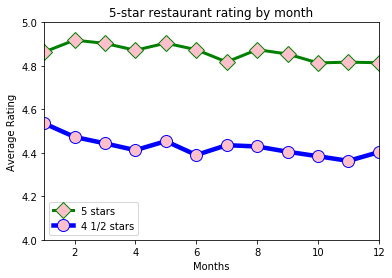

In [95]:
plt.plot(month_stars[month_stars['stars'] == 5]['month'], month_stars[month_stars['stars'] == 5]['scores'], label='5 stars',linewidth=3,color='g',marker='D', markerfacecolor='pink',markersize=12)
plt.plot(month_stars[month_stars['stars'] == 4.5]['month'], month_stars[month_stars['stars'] == 4.5]['scores'], label='4 1/2 stars',linewidth=4.5,color='b',marker='o', markerfacecolor='pink',markersize=12)
plt.axis([1, 12, 4, 5])
plt.title('5-star restaurant rating by month')
plt.xlabel('Months') 
plt.ylabel('Average Rating') 
plt.legend() 
plt.show()

* There are no significant difference in trend between 5-star and 4.5-star restaurants.

### Count the restaurants by category

In [21]:
sql = '''
      SELECT b.category, a.stars, 
      count(*) as numbers 
      FROM 
      (SELECT state,id,name,stars FROM business 
      join category on category.business_id=business.id 
      where business.state like "AZ"
      AND category.category="Restaurants") as a
      join category as b 
      on a.id = b.business_id 
      where b.category not in ("Restaurants", "Food", "Event Planning & Services") 
      group by category
      order by numbers DESC
      limit 10;
      '''

business_2 = pd.io.sql.read_sql(sql, conn)
print(business_2)

                 category  stars  numbers
0               Fast Food    3.0     1670
1                 Mexican    4.0     1547
2              Sandwiches    2.0     1529
3  American (Traditional)    3.0     1431
4               Nightlife    3.0     1380
5                    Bars    3.0     1317
6                   Pizza    2.0     1281
7          American (New)    4.0     1106
8                 Burgers    2.0      991
9      Breakfast & Brunch    4.0      911


Text(0,0.5,'numbers')

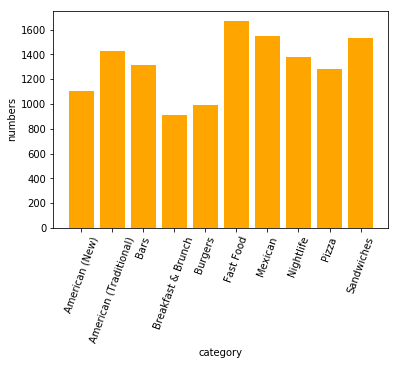

In [22]:
plt.bar(business_2['category'],business_2['numbers'], color = 'orange')  
plt.xticks(rotation = 70)
plt.xlabel('category')  
plt.ylabel('numbers')  

* The top 3 5-star restaurant catogories are Fast Food, Sandwiches and Mexican.

### Count restaurants by category (5-star VS. 4.5-star)

In [26]:
sql = '''
      SELECT b.category,
      count(*) as numbers
      FROM
      (SELECT state,id,name FROM business 
      join category on category.business_id=business.id 
      where business.state like "AZ" 
      AND category.category="Restaurants"
      AND business.stars = 5) as a
      join category as b 
      on a.id = b.business_id 
      where b.category not in ("Restaurants", "Food", "Event Planning & Services")
      group by b.category
      order by numbers desc
      limit 10;
      '''
business_2_0 = pd.io.sql.read_sql(sql, conn)
print(business_2_0)

             category  numbers
0          Sandwiches       37
1             Mexican       31
2               Cafes       29
3  Breakfast & Brunch       27
4         Food Trucks       24
5        Coffee & Tea       23
6            Bakeries       20
7            Caterers       20
8      Specialty Food       19
9               Pizza       18


In [27]:
sql = '''
      SELECT b.category,
      count(*) as numbers
      FROM
      (SELECT state,id,name FROM business 
      join category on category.business_id=business.id 
      where business.state like "AZ" 
      AND category.category="Restaurants"
      AND business.stars < 5) as a
      join category as b 
      on a.id = b.business_id 
      where b.category not in ("Restaurants", "Food", "Event Planning & Services")
      group by b.category
      order by numbers desc
      limit 10;
      '''
business_2_1 = pd.io.sql.read_sql(sql, conn)
print(business_2_1)

                 category  numbers
0               Fast Food     1663
1                 Mexican     1516
2              Sandwiches     1492
3  American (Traditional)     1415
4               Nightlife     1368
5                    Bars     1308
6                   Pizza     1263
7          American (New)     1096
8                 Burgers      978
9      Breakfast & Brunch      884


Text(0,0.5,'numbers')

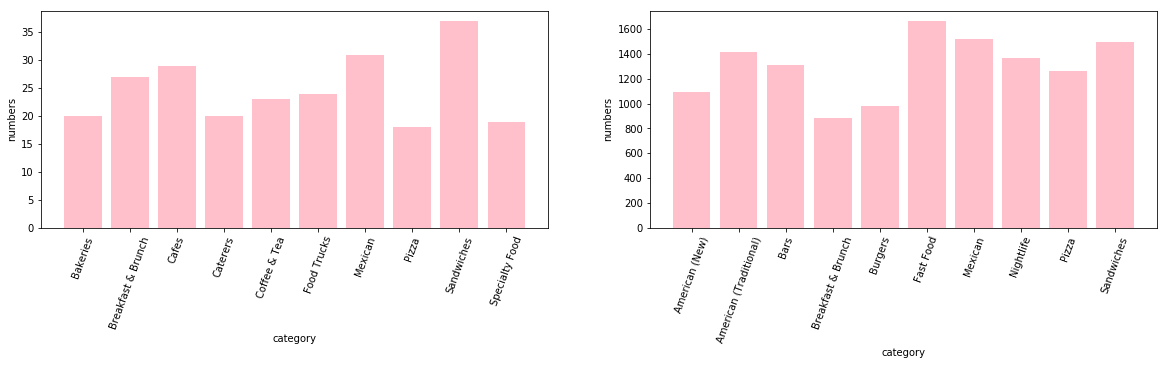

In [28]:
fig = plt.figure(figsize=[20,4])
fig.add_subplot(121)
plt.bar(business_2_0['category'], business_2_0['numbers'], color = 'pink')  
plt.xticks(rotation = 70)
plt.xlabel('category')  
plt.ylabel('numbers')
fig.add_subplot(122)
plt.bar(business_2_1['category'], business_2_1['numbers'], color = 'pink')  
plt.xticks(rotation = 70)
plt.xlabel('category')  
plt.ylabel('numbers')

* Fast Food is not in the top 10 of non 5-star restaurants while Fast Food has the most restaurants among the non 5-star restaurants.

### Make scatter plot by restaurant star and count for Fast Food, Mexican and Sandwiches

In [99]:
sql = '''
      SELECT b.category, a.stars, 
      count(1) as numbers
      FROM 
      (SELECT state,id,name,stars 
      FROM business 
      join category
      on category.business_id=business.id 
      where business.state like "AZ" 
      AND category.category="Restaurants") as a
      join category as b 
      on a.id = b.business_id 
      where b.category not in ("Restaurants", "Food")
      group by b.category, a.stars
      order by b.category, a.stars;
      '''
business_2_2 = pd.io.sql.read_sql(sql, conn)

In [100]:
sql = '''
      SELECT b.category, 
      count(1) as sum
      FROM 
      (SELECT state,id,name
      FROM business 
      join category
      on category.business_id=business.id 
      where business.state like "AZ" 
      AND category.category="Restaurants") as a
      join category as b 
      on a.id = b.business_id 
      where b.category <> "Restaurants" 
      group by b.category
      order by b.category;
      '''
business_2_3 = pd.io.sql.read_sql(sql, conn)

In [101]:
business_2_4 = business_2_2.merge(business_2_3)
business_2_5 = business_2_4[business_2_4['sum'] > 1500]

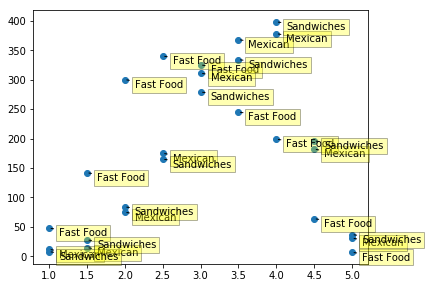

In [102]:
labels = [i for i in business_2_5.category]
plt.subplots_adjust(bottom = 0)
plt.scatter(x=business_2_5['stars'], y=business_2_5['numbers'])
for label, x, y in zip(labels,business_2_5.stars,business_2_5.numbers):
    plt.annotate(label,xy=(x,y),xytext=(10, -10),
    textcoords='offset points',va='bottom',
    bbox=dict(boxstyle='square,pad=0.3', fc='yellow', alpha=0.3),
    arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))

* For 3.5-star and above restaurants, there are more the Sandwiches and Mexican restaurants than Fast Food while for other restaurants, there are more Fast Food Restauranrs.

### Explore whether there is a relationship between the five-star restaurants and their review text length.

In [110]:
sql = '''
      SELECT review.text, business.stars
      from business
      join review
      on review.business_id = business.id
      join category
      on category.business_id = business.id
      where category.category = 'Restaurants'
      and business.state = 'AZ'
      group by business.id;
      '''
review = pd.io.sql.read_sql(sql, conn) 

In [111]:
def process_data(myList):
    a = ''. join(myList)#convert list into a string
    import re
    a = re.sub('[^A-Za-z0-9]+', ' ', a)#remove all punctuations
    a = ''.join([i for i in a if not i.isdigit()])#remove all blankspaces
    a = a[0:-1].lower()#all lowercase
    a1 = a.split (' ')
    a1 = [tup for tup in a1 if tup != '']
    a3 = " ".join(x for x in a1)
    a2 = len(a3)
    #length = max(len(l) for l in a1)#I calculate the longest words length but I can't apply this length in next function    
    #import itertools
    #aaa = {x:len(list(y)) for x,y in itertools.groupby(sorted(a1))}#count the number of the word count and create a dictionary containing both counts and words
    return a2

In [112]:
text_count = review['text'].apply(process_data)
review['text_count'] = text_count

In [113]:
import statsmodels.formula.api as smf
model1 = smf.ols(formula='text_count ~ stars', data=review).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             text_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.057
Date:                Wed, 06 Dec 2017   Prob (F-statistic):            0.00454
Time:                        15:53:33   Log-Likelihood:                -77762.
No. Observations:               10219   AIC:                         1.555e+05
Df Residuals:                   10217   BIC:                         1.555e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    582.5615     21.168     27.521      0.000     541.069     624.054
stars        -17.1523      6.043     -2.838      0.005     -28.998      -5.307
==============================================================================
Omnibus:                     6215.338   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73872.174
Skew:                           2.759   Prob(JB):                         0.00
Kurtosis:                      14.961   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
import seaborn as sns

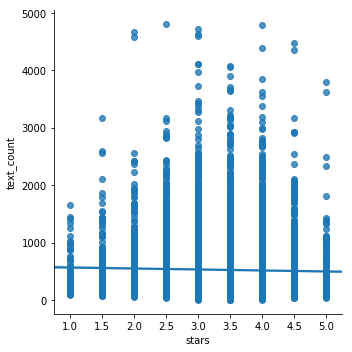

In [115]:
sns.lmplot(x = 'stars', y= 'text_count', data=review)
plt.show()

* We use remove all the punctuation, leave only the text part and use “statsmodels” to identify their relationships. At last, we find there is no relationship between them.

### Words have the highest frequency in five-star restaurants reviews compare with words have the highest frequency in non-five-star reviews

In [116]:
import nltk
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords

In [117]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [118]:
from nltk.probability import FreqDist

In [119]:
sql = '''
      SELECT review.text
      from business
      join review
      on review.business_id = business.id
      join category
      on category.business_id = business.id
      where business.stars = 5
      and category.category = 'Restaurants'
      and business.state = 'AZ'
      group by business.id;
      '''
five_star_res_review = pd.io.sql.read_sql(sql, conn) 

In [120]:
five_star_res_review['new_text'] = five_star_res_review['text'].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n]','')
five_star_res_review['new_text'] = five_star_res_review['new_text'].str.lower()
a = ' '.join(five_star_res_review['new_text'])

In [121]:
stop = set(stopwords.words('english'))
b = [i for i in a.lower().split() if i not in stop]
b = ' '.join(b)

In [122]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Russell Xing\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [123]:
tagged_sent = pos_tag(b.split())

In [124]:
propernouns = [word for word,pos in tagged_sent if pos == 'NN']
propernouns2 = [word for word,pos in tagged_sent if pos == 'JJ']

In [125]:
c = ' '.join(propernouns)
words = nltk.tokenize.word_tokenize(c)
fdist= FreqDist(words)
five_nn = pd.DataFrame(list(fdist.items()), columns=['word', 'count'])

In [126]:
c2 = ' '.join(propernouns2)
words2 = nltk.tokenize.word_tokenize(c2)
fdist2= FreqDist(words2)
five_adj = pd.DataFrame(list(fdist2.items()), columns=['word', 'count'])

In [131]:
sql = '''
      SELECT review.text
      from business
      join review
      on review.business_id = business.id
      join category
      on category.business_id = business.id
      where business.stars != 5
      and category.category = 'Restaurants'
      and business.state = 'AZ'
      group by business.id;
      '''
non_star_res_review = pd.io.sql.read_sql(sql, conn) 

In [132]:
non_star_res_review['new_text'] = non_star_res_review['text'].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n]','')
non_star_res_review['new_text'] = non_star_res_review['new_text'].str.lower()
aa = ' '.join(non_star_res_review['new_text'])

In [133]:
stop = set(stopwords.words('english'))
bb = [i for i in aa.lower().split() if i not in stop]
bb = ' '.join(bb)
tagged_sent2 = pos_tag(bb.split())

In [137]:
propernouns4 = [word for word,pos in tagged_sent2 if pos == 'NN']
propernouns44 = [word for word,pos in tagged_sent2 if pos == 'JJ']

In [138]:
cc = ' '.join(propernouns4)
words4 = nltk.tokenize.word_tokenize(cc)
fdist4= FreqDist(words4)
non_nn = pd.DataFrame(list(fdist4.items()), columns=['word', 'count'])

In [141]:
cc44 = ' '.join(propernouns44)
words44 = nltk.tokenize.word_tokenize(cc44)
fdist44= FreqDist(words44)
non_adj = pd.DataFrame(list(fdist44.items()), columns=['word', 'count'])

In [128]:
from wordcloud import WordCloud

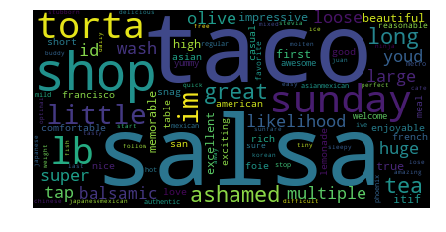

In [129]:
wordcloud = WordCloud(max_words=100).generate(' '.join(five_adj['word']))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('1.1adj.png', figsize=(15,5), dpi=500)
plt.show()

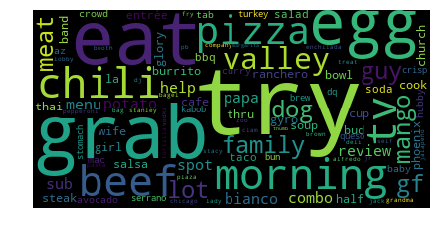

In [139]:
wordcloud = WordCloud(max_words=100).generate(' '.join(non_nn['word']))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('2.1noun.png', figsize=(15,5), dpi=500)
plt.show()

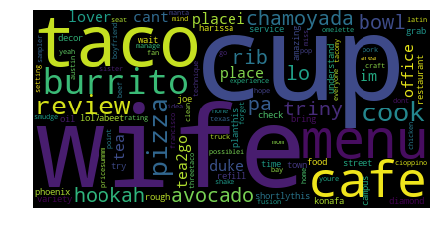

In [130]:
wordcloud = WordCloud(max_words=100).generate(' '.join(five_nn['word']))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('1.2noun.png', figsize=(15,5), dpi=500)
plt.show()

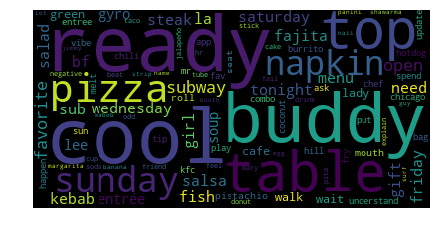

In [142]:
wordcloud = WordCloud(max_words=100).generate(' '.join(non_adj['word']))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('2.2adj.png', figsize=(15,5), dpi=500)
plt.show()

In [143]:
merge = five_nn.merge(non_nn, on = ['word'], how = 'left')
merge = merge.fillna(0)

In [144]:
a = ['youre','im','dont']
merge1 = merge[~merge.word.isin(a)]
test = merge1.sort_values('count_x', ascending = False).head(30).reset_index()

In [145]:
import matplotlib.lines as mlines

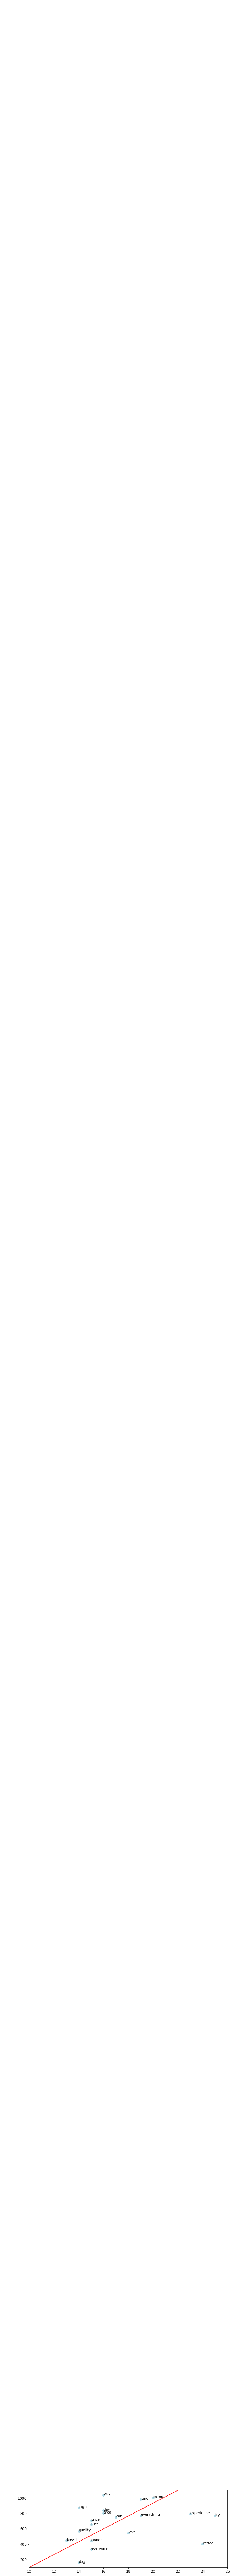

In [146]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(1,1,1)
ax.scatter(test['count_x'],test['count_y'],c='lightblue')
for i in range(len(test['word'])):
    ax.annotate(test['word'][i],(test['count_x'][i],test['count_y'][i]))
ax.axis([10,26,100,1100])
line = mlines.Line2D([0, 1.5], [0, 2], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.show()

* We remove all irrelevant words and punctuations and categorize other words. Then, we count all these words in five-star restaurants and non-five-star restaurants and find some words like “dogs”, “coffee” and “love” appear to have high word frequencies in a lot of five-star restaurants. However, in non-five-star restaurants, we are not seeing them very often. 

### Attributes differences in five-star restaurants and non-five-star restaurants

In [151]:
sql = '''
      SELECT attribute.name, count(attribute.name) AS count
      from attribute
      join business
      on attribute.business_id = business.id
      join category
      on category.business_id = business.id
      where category.category = 'Restaurants'
      and business.state = 'AZ'
      and business.stars = 5
      group by attribute.name
      order by attribute.name, business.stars;
      '''
count_x_sum = pd.io.sql.read_sql(sql, conn) 

In [152]:
sql = '''
      SELECT attribute.name, attribute.value, count(attribute.value) AS count
      from attribute
      join business
      on attribute.business_id = business.id
      join category
      on category.business_id = business.id
      where category.category = 'Restaurants'
      and business.state = 'AZ'
      and business.stars = 5
      and attribute.value not like '{%'
      group by attribute.name, attribute.value
      order by attribute.name, business.stars;
      '''
high_score_attribute = pd.io.sql.read_sql(sql, conn) 

In [153]:
high_score_attribute_merge = high_score_attribute.merge(count_x_sum, on = ['name'], how = 'outer')
high_score_attribute_merge['high_star_rate'] = high_score_attribute_merge['count_x'].div(high_score_attribute_merge['count_y'])

In [147]:
sql = '''
      SELECT attribute.name, attribute.value, count(*) AS count
      from attribute
      join business
      on attribute.business_id = business.id
      join category
      on category.business_id = business.id
      where category.category = 'Restaurants'
      and business.state = 'AZ'
      and business.stars != 5
      and attribute.value not like '{%'
      group by attribute.name, attribute.value
      order by attribute.name, business.stars;
      '''
count_y_sum = pd.io.sql.read_sql(sql, conn) 

In [148]:
sql = '''
      SELECT attribute.name, count(*) AS count
      from attribute
      join business
      on attribute.business_id = business.id
      join category
      on category.business_id = business.id
      where category.category = 'Restaurants'
      and business.state = 'AZ'
      and business.stars != 5
      group by attribute.name
      order by attribute.name, business.stars;
      '''
low_score_attribute = pd.io.sql.read_sql(sql, conn) 

In [149]:
low_score_attribute_merge = count_y_sum.merge(low_score_attribute, on = ['name'], how = 'outer')
low_score_attribute_merge['low_star_rate'] = low_score_attribute_merge['count_x'].div(low_score_attribute_merge['count_y'])

In [154]:
score_attribute_merge = high_score_attribute_merge.merge(low_score_attribute_merge, on = ['name','value'], how = 'left')
score_attribute_merge_ratio = score_attribute_merge[['name','value','count_y_x','high_star_rate','count_y_y', 'low_star_rate']]
score_attribute_merge_ratio = score_attribute_merge_ratio.dropna(axis=0, how='any') 

In [155]:
sql = '''
      SELECT attribute.name, count(*) AS count
      from attribute
      join business
      on attribute.business_id = business.id
      join category
      on category.business_id = business.id
      where category.category = 'Restaurants'
      and business.state = 'AZ'
      and business.stars is not null
      and attribute.name is not null
      and attribute.value is not null
      group by attribute.name
      order by attribute.name;
      '''
total_score_attribute = pd.io.sql.read_sql(sql, conn) 

In [156]:
a = []
for i in (score_attribute_merge_ratio['value']):
    if i == '0':
        a.append('_YES')
    elif i == '1':
        a.append('_NO')
    else:
        a.append(' '+i)
score_attribute_merge_ratio.loc[:,'value_str'] = pd.Series(a, index=score_attribute_merge_ratio.index)

In [157]:
score_attribute_merge_ratio['name_value'] = score_attribute_merge_ratio[['name', 'value_str']].apply(lambda x: ''.join(x), axis=1)

In [174]:
final = score_attribute_merge_ratio[['name_value','count_y_x','high_star_rate','count_y_y','low_star_rate']]
final = final[final['count_y_x']>80].reset_index()

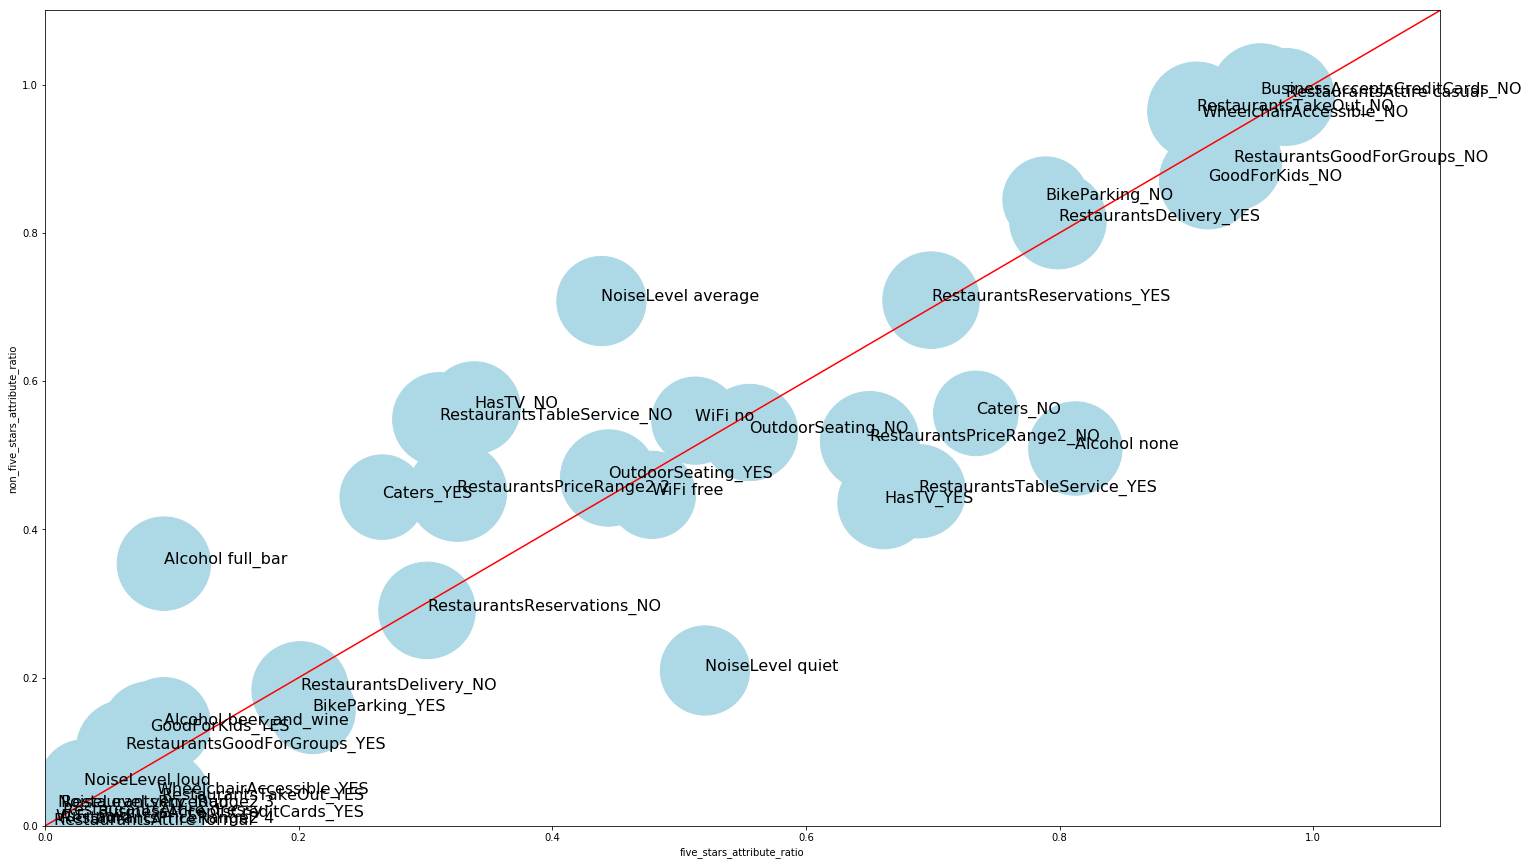

In [180]:
plt.clf()
fig = plt.figure(figsize=[25,15])
ax = fig.add_subplot(1,1,1)
ax.scatter(final['high_star_rate'],final['low_star_rate'],c='lightblue', s =final['count_y_y']+final['count_y_x'])
for i in range(len(final['name_value'])):
    ax.annotate(final['name_value'][i],(final['high_star_rate'][i],final['low_star_rate'][i]),fontsize=16)
ax.axis([0,1.1,0,1.1])
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel('five_stars_attribute_ratio')
plt.ylabel('non_five_stars_attribute_ratio')
plt.show()

* We find that the attributes and their values like “NoiseLevel quiet”, “HasTV_YES” and “RestaurantsTableService_YES” appear more often in five-star restaurants than in non-five-star restaurants.

### Do higher-starred Yelp reviews mean higher likelihood of business survival? (NO).

In [86]:
sql = '''
      SELECT count(review.stars) as starclass_count, category.category as category, business.stars as stars,
            business.is_open as in_business 
      FROM review, business, category 
      WHERE state Like "AZ" 
      AND category Like "Restaurants" 
      AND review.business_id = business.id 
      AND category.business_id = business.id 
      GROUP BY category.category, business.stars, business.is_open
      ORDER by stars DESC;
      '''
business_survival_by_star = pd.io.sql.read_sql(sql, conn)
print(business_survival_by_star)

    starclass_count     category  stars  in_business
0              4528  Restaurants    5.0            1
1               801  Restaurants    5.0            0
2              8933  Restaurants    4.5            0
3            128436  Restaurants    4.5            1
4             38273  Restaurants    4.0            0
5            297577  Restaurants    4.0            1
6             38436  Restaurants    3.5            0
7            173296  Restaurants    3.5            1
8             70326  Restaurants    3.0            1
9             23160  Restaurants    3.0            0
10             8404  Restaurants    2.5            0
11            29862  Restaurants    2.5            1
12             2028  Restaurants    2.0            0
13             8950  Restaurants    2.0            1
14             3395  Restaurants    1.5            1
15              279  Restaurants    1.5            0
16              493  Restaurants    1.0            1
17               63  Restaurants    1.0       

### Do higher-starred Yelp reviews mean higher likelihood of business survival? Better way (NO).

In [87]:
sql = '''
      SELECT count(business.stars) as busnum, business.stars as stars, business.is_open as in_business \
      FROM business, category
      WHERE state Like "AZ"
      AND category Like "Restaurants"
      AND category.business_id = business.id
      GROUP BY business.stars, in_business
      ORDER by stars DESC;
      '''
bsbs2 = pd.io.sql.read_sql(sql, conn)
print(bsbs2)

    busnum  stars  in_business
0       59    5.0            0
1      163    5.0            1
2      255    4.5            0
3      838    4.5            1
4      720    4.0            0
5     1854    4.0            1
6      819    3.5            0
7     1621    3.5            1
8      678    3.0            0
9     1149    3.0            1
10     335    2.5            0
11     804    2.5            1
12     131    2.0            0
13     487    2.0            1
14      37    1.5            0
15     197    1.5            1
16      12    1.0            0
17      60    1.0            1


### Do higher-starred Yelp reviews mean higher likelihood of business survival? Better way (NO).

In [88]:
sql = '''
      SELECT count(business.stars) as busnum, business.stars as stars, business.is_open as in_business
      FROM business, category
      WHERE state Like "AZ"
      AND category Like "Restaurants"
      AND category.business_id = business.id
      AND business.is_open = 1
      GROUP BY business.stars, business.is_open
      ORDER by stars DESC;
      '''
bsbs3 = pd.io.sql.read_sql(sql, conn)
print(bsbs3)

   busnum  stars  in_business
0     163    5.0            1
1     838    4.5            1
2    1854    4.0            1
3    1621    3.5            1
4    1149    3.0            1
5     804    2.5            1
6     487    2.0            1
7     197    1.5            1
8      60    1.0            1


In [89]:
sql = '''
      SELECT count(business.stars) as busnum, business.stars as stars 
      FROM business, category 
      WHERE state Like "AZ" 
      AND category Like "Restaurants" 
      AND category.business_id = business.id 
      GROUP BY business.stars
      ORDER by stars DESC;
      '''
bsbs4 = pd.io.sql.read_sql(sql, conn)
bsbs4['surv_rate']=bsbs3['busnum']/bsbs4['busnum']
print(bsbs4)

   busnum  stars  surv_rate
0     222    5.0   0.734234
1    1093    4.5   0.766697
2    2574    4.0   0.720280
3    2440    3.5   0.664344
4    1827    3.0   0.628900
5    1139    2.5   0.705882
6     618    2.0   0.788026
7     234    1.5   0.841880
8      72    1.0   0.833333


Text(0,0.5,'surv_rate')

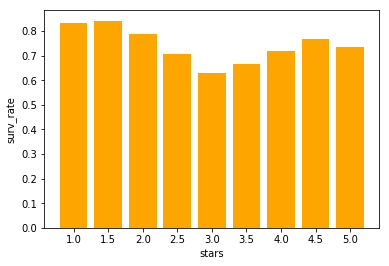

In [90]:
bsbs4['stars'] = bsbs4['stars'].astype('str')
plt.bar(bsbs4['stars'],bsbs4['surv_rate'], color = 'orange')  
plt.xlabel('stars')  
plt.ylabel('surv_rate') 

* For restaurant, the highest star rating doesn't mean the highest survival rate. 1-star or 1.5-star restaurants share the top two survival rate. Even 5-star cannot make sure your restaurants survive for long.